In [1]:
# Importing necessary libraries for data fetching, processing, and visualization

# fetch_ucirepo is used to fetch datasets from the UCI Machine Learning Repository
from ucimlrepo import fetch_ucirepo

# NumPy is used for numerical operations on multi-dimensional arrays and matrices
import numpy as np

# Matplotlib's pyplot and Seaborn are used for creating static, animated, and interactive visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Importing necessary libraries for machine learning and model evaluation

# TensorFlow is a library for machine learning and neural networks
import tensorflow as tf

# Keras is a high-level neural networks API, capable of running on top of TensorFlow
# We're importing its layers and models modules
from tensorflow.keras import layers, models

# sklearn's model_selection module provides utilities for splitting datasets
# Here we're importing KFold for cross-validation
from sklearn.model_selection import KFold

# sklearn's preprocessing module provides utilities for scaling features
# Here we're importing MinMaxScaler for scaling features to a given range
from sklearn.preprocessing import MinMaxScaler

# sklearn's metrics module provides utilities for model evaluation
# Here we're importing accuracy_score, confusion_matrix, and classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

2024-05-01 17:02:16.521628: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 17:02:17.931955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Fetching the dataset
# The fetch_ucirepo function is used to fetch a dataset from the UCI Machine Learning Repository
# Here we're fetching the dataset with the ID 80, which is the Optical Recognition of Handwritten Digits dataset
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80)

# Extracting the features and targets from the dataset
# The features are stored in X and the targets are stored in y
X = optical_recognition_of_handwritten_digits.data.features
y = optical_recognition_of_handwritten_digits.data.targets

# Converting the features and targets from pandas dataframes to NumPy arrays
# This is necessary for the subsequent processing and the use with TensorFlow
X = X.values
y = y.values

# Reshaping the data for the Convolutional Neural Network (CNN)
# The data is reshaped to (-1, 8, 8, 1), which is the shape expected by the CNN
# The -1 in the reshape function is used when you aren't sure about the dimension and you want NumPy to calculate it for you
X = X.reshape(-1, 8, 8, 1)

# Normalizing the data for the CNN
# The data is normalized to a range between 0 and 1 using the MinMaxScaler
# This helps to improve the performance of the CNN
scaler = MinMaxScaler()

# The data is first reshaped to (-1, 64) because the MinMaxScaler expects a 2D array
# After the scaling, it is reshaped back to (-1, 8, 8, 1) for the CNN
X_normalized = scaler.fit_transform(X.reshape(-1, 64))  # Reshape for MinMaxScaler
X_normalized = X_normalized.reshape(-1, 8, 8, 1)

In [5]:
# Define the Convolutional Neural Network (CNN) model
def create_model():
    # Initialize the model using the Sequential API
    # This allows us to create models layer-by-layer
    model = models.Sequential([

        # Convolutional Layer 1
        # This layer will have 32 filters, each of size (3, 3)
        # The activation function is ReLU (Rectified Linear Unit)
        # The padding is set to 'same' which means the output has the same width and height as the input
        # The input shape is (8, 8, 1) which is the shape of our images
        layers.Conv2D(8, (3, 3), activation = 'relu', padding = 'same', input_shape = (8, 8, 1)),

        # Padding Layer
        # This layer will add zeros around the input image to help the convolutional layer extract features at the edges
        layers.ZeroPadding2D((1, 1)),

        # Max Pooling Layer 1
        # This layer will downsample the input along its spatial dimensions (width and height) by taking the maximum value over an input window of size (2, 2)
        layers.MaxPooling2D((2, 2)),

        # Convolutional Layer 2
        # This layer will have 64 filters, each of size (3, 3)
        # The activation function is again ReLU
        layers.Conv2D(16, (3, 3), activation='relu', padding = 'same'),

        # Max Pooling Layer 2
        # This layer will again downsample the input along its spatial dimensions
        layers.MaxPooling2D((2, 2)),

        # Convolutional Layer 3
        # This layer will have 128 filters, each of size (3, 3)
        # The activation function is again ReLU
        layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'),

        # Flattening Layer
        # This layer will flatten the 3D outputs of the last convolutional layer into 1D
        # This is necessary before passing the outputs to the fully connected layer
        layers.Flatten(),

        # Fully Connected Layer 1
        # This layer will have 64 neurons and use the ReLU activation function
        layers.Dense(32, activation='relu'),

        # Output Layer
        # This layer will have 10 neurons (one for each class) and use the softmax activation function
        # The softmax function will output a probability distribution over the 10 classes, which sums to 1
        layers.Dense(10, activation='softmax')
    ])

    # Compile the model
    # The optimizer is Adam, the loss function is sparse categorical crossentropy, and we would like to track accuracy as a metric
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Return the compiled model
    return model

/home/dudamdattu/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


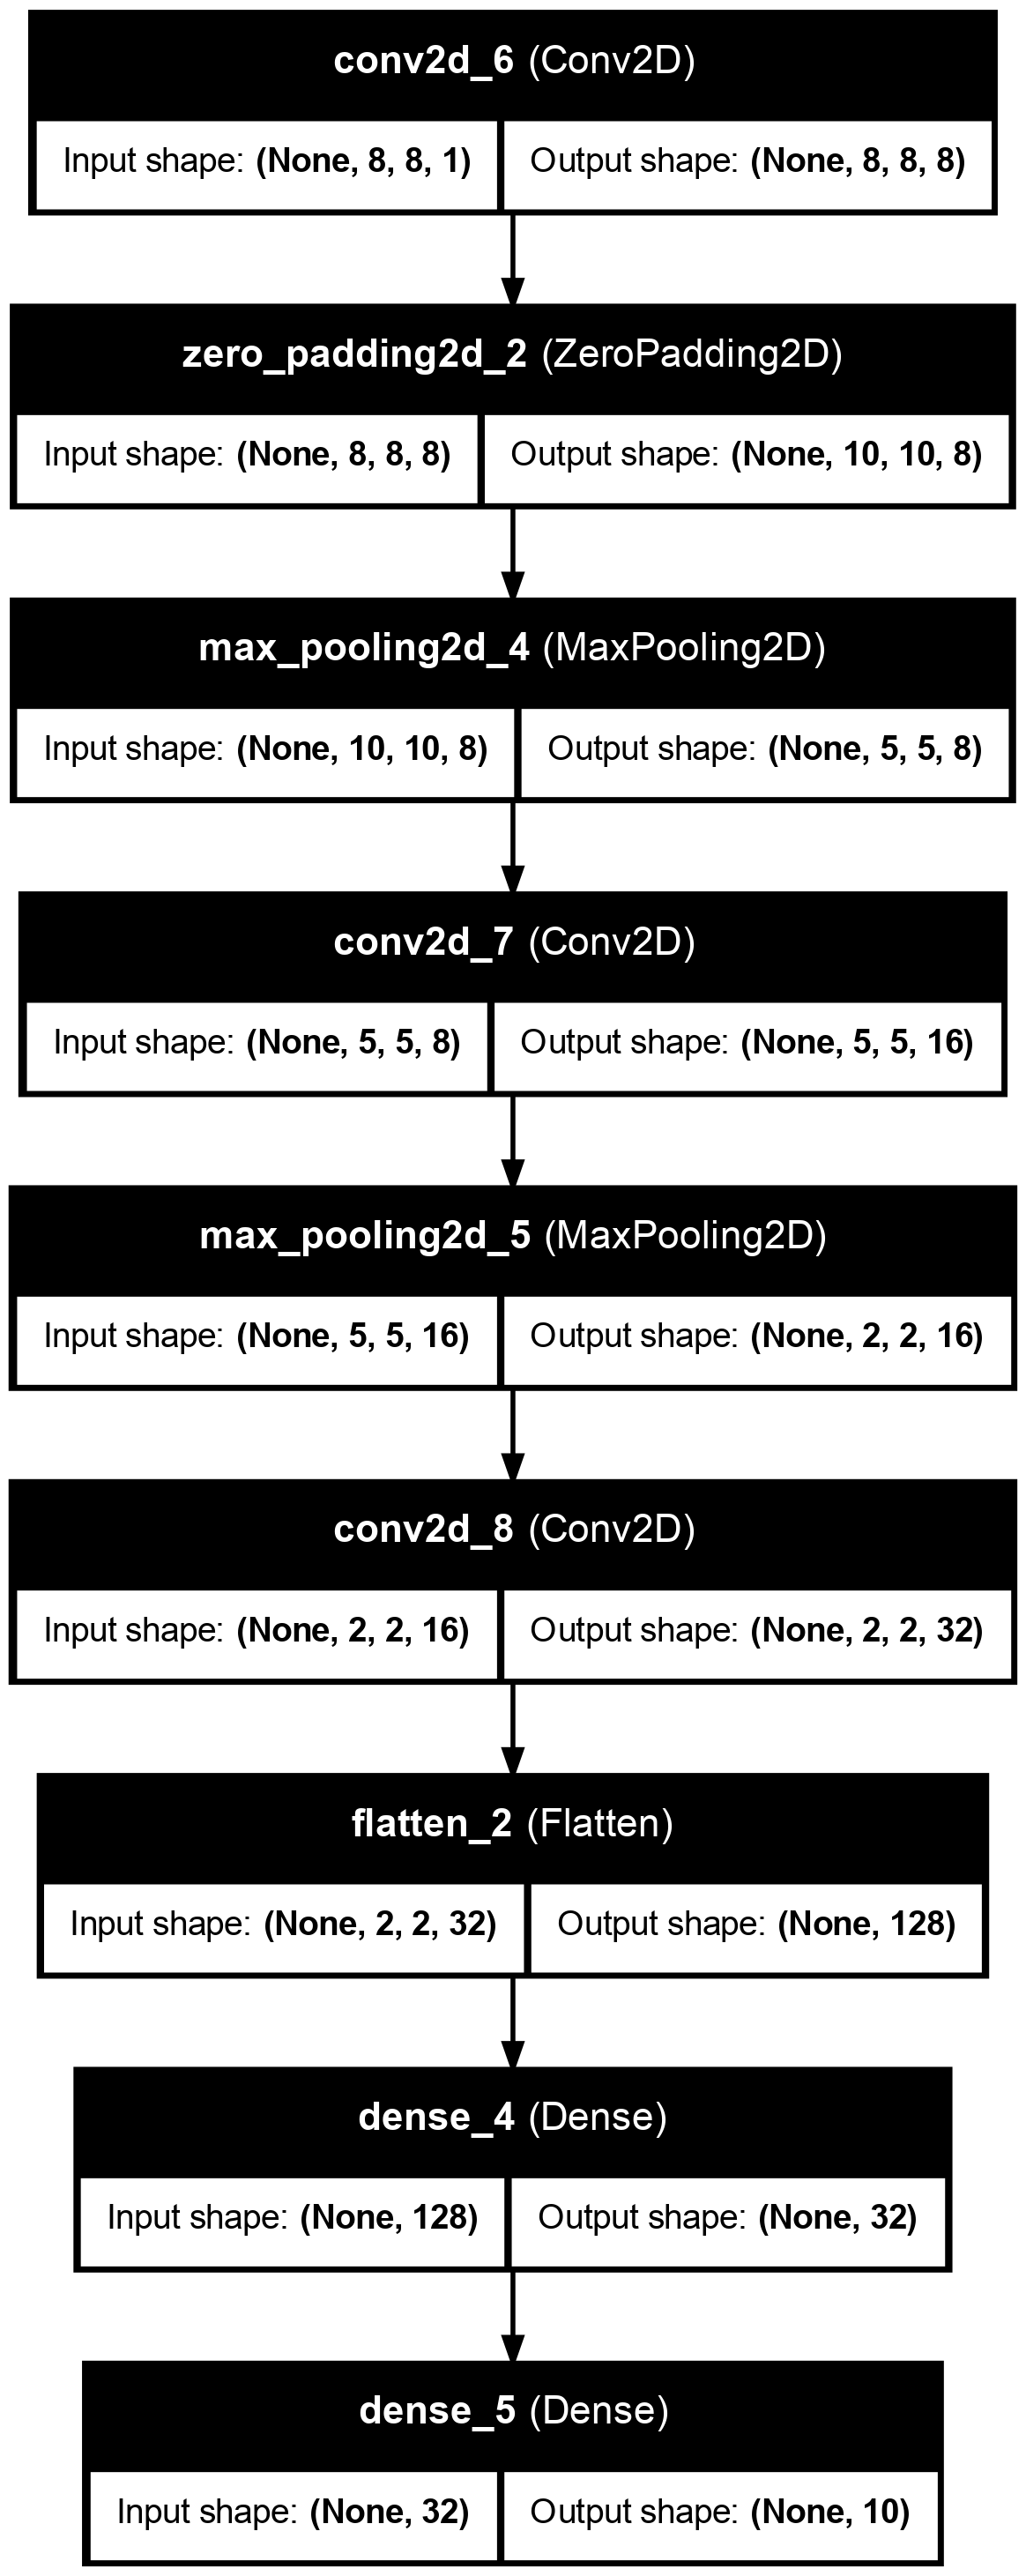

In [7]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
model = create_model()
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

In [5]:
# Define the number of folds for k-fold cross-validation
# Here we're using 5 folds, which is a common choice
k = 5

# Initialize the KFold object from sklearn
# n_splits is set to k, which is the number of folds
# shuffle is set to True, which means the data will be shuffled before splitting into folds
# random_state is set to 42, which is a common choice for reproducibility
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store the results of the cross-validation
# fold_accuracy will store the accuracy of the model on each fold
# fold_loss will store the loss of the model on each fold
# all_y_true will store the true labels of the samples
# all_y_pred will store the predicted labels of the samples
fold_accuracy = []
fold_loss = []
all_y_true = []
all_y_pred = []

In [6]:
# Initialize an empty list to store the accuracy of the model on each fold
fold_accuracy = []

# Perform k-fold cross-validation
# The kf.split(X) function returns indices for the train and validation sets for each fold
for train_index, val_index in kf.split(X):
    # Use the indices to create the train and validation sets
    # The train set is used to train the model, and the validation set is used to evaluate it
    X_train, X_val = X_normalized[train_index], X_normalized[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Create a new instance of the model for each fold
    model = create_model()

    # Train the model on the train set for 50 epochs
    # An epoch is one complete pass through the entire train set
    # The batch size is set to 32, which means the model will update its weights after looking at 32 samples
    # The validation set is passed to the fit function using the validation_data argument
    # This allows us to track the loss and accuracy on the validation set during training
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50


/home/usd.local/sonyreddy.gurram/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4632 - loss: 1.5797 - val_accuracy: 0.9155 - val_loss: 0.2785
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9359 - loss: 0.2107 - val_accuracy: 0.9404 - val_loss: 0.1731
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9706 - loss: 0.1121 - val_accuracy: 0.9635 - val_loss: 0.1348
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9814 - loss: 0.0801 - val_accuracy: 0.9493 - val_loss: 0.1778
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9795 - loss: 0.0721 - val_accuracy: 0.9786 - val_loss: 0.0767
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9783 - loss: 0.0570 - val_accuracy: 0.9733 - val_loss: 0.0858
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9858 - loss: 0.0413 - val_accuracy: 0.9778 - val_loss: 0.0722
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9888 - loss: 0.0331 - val_accuracy: 0.9804 - val_

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Average validation accuracy across folds: [0.94483984 0.96975088 0.97686833 0.97508895 0.96708184 0.98843414
 0.97775799 0.98665482 0.98843414 0.98843414 0.98843414 0.99199289
 0.98843414 0.98665482 0.98843414 0.98932385 0.99021351 0.98754448
 0.99288255 0.98309606 0.98487544 0.98042703 0.97953737 0.98754448
 0.98932385 0.98932385 0.98932385 0.98932385 0.98932385 0.98932385
 0.98932385 0.98932385 0.98932385 0.98932385 0.98932385 0.98932385
 0.98932385 0.98932385 0.98932385 0.98932385 0.98932385 0.98932385
 0.98932385 0.98932385 0.98932385 0.98932385 0.98932385 0.98932385
 0.98932385 0.98932385]


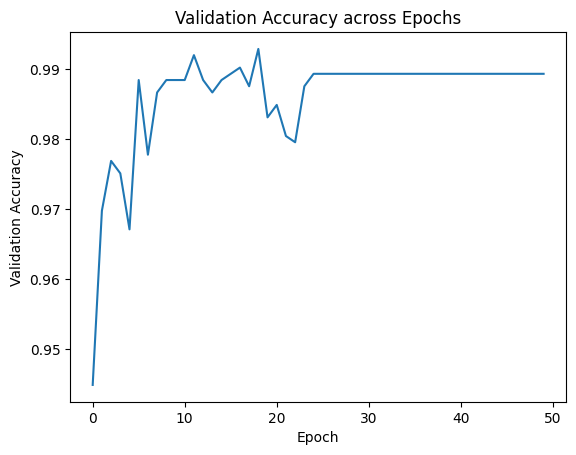

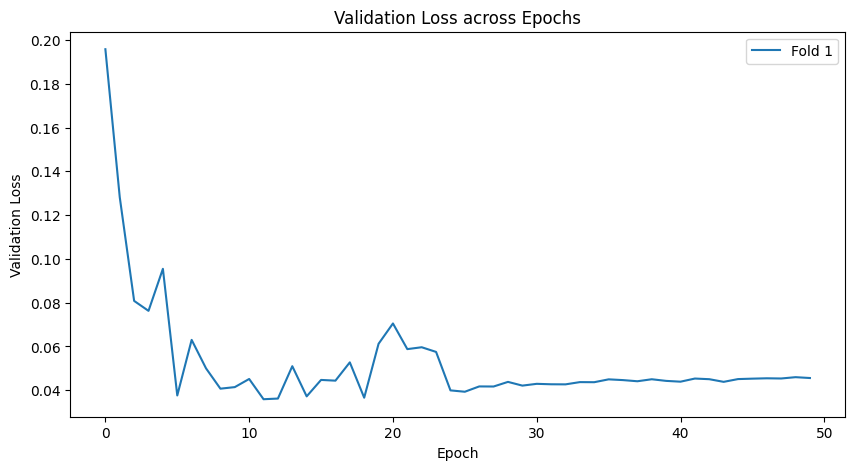

Overall accuracy: 0.9893238434163701


In [7]:
# Record the accuracy and loss on the validation set for each fold
# These are stored in the history object returned by the fit function
fold_accuracy.append(history.history['val_accuracy'])
fold_loss.append(history.history['val_loss'])

# Make predictions on the validation set
# The model's predict function returns a probability distribution over the classes
# We use np.argmax to get the class with the highest probability
y_pred = np.argmax(model.predict(X_val), axis=1)

# Extend the lists with the true and predicted labels
# These will be used to calculate the overall accuracy after the cross-validation
all_y_true.extend(y_val)
all_y_pred.extend(y_pred)

# Calculate the average validation accuracy across the folds
# This is done by taking the mean of the fold_accuracy list along axis 0
avg_val_accuracy = np.mean(fold_accuracy, axis=0)

# Print the average validation accuracy
print('Average validation accuracy across folds:', avg_val_accuracy)

# Plot the average validation accuracy across epochs
plt.plot(avg_val_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy across Epochs')
plt.show()

# Plot the validation loss for each fold across epochs
plt.figure(figsize=(10, 5))
for i in range(len(fold_loss)):
    plt.plot(history.epoch, fold_loss[i], label=f'Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss across Epochs')
plt.legend()
plt.show()

# Calculate the overall accuracy
# This is done by comparing the true labels (all_y_true) with the predicted labels (all_y_pred)
overall_accuracy = accuracy_score(all_y_true, all_y_pred)

# Print the overall accuracy
print('Overall accuracy:', overall_accuracy)

In [8]:
classification_report = classification_report(y_val, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       107
           1       0.95      0.99      0.97       104
           2       1.00      0.99      1.00       114
           3       1.00      0.99      1.00       113
           4       1.00      0.97      0.99       112
           5       0.98      1.00      0.99       111
           6       1.00      1.00      1.00       110
           7       0.99      1.00      1.00       114
           8       0.99      0.97      0.98       125
           9       0.98      0.99      0.99       114

    accuracy                           0.99      1124
   macro avg       0.99      0.99      0.99      1124
weighted avg       0.99      0.99      0.99      1124



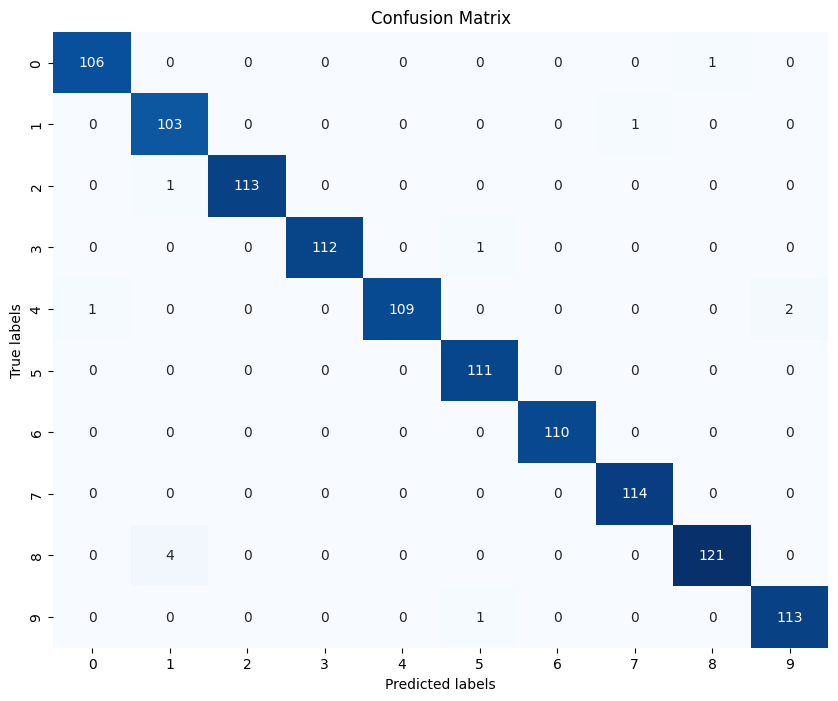

In [9]:
# Confusion matrix
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()